In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def load_iris(ratio=0.8):
    features, target = datasets.load_iris(True)

    # 只保留0,1分类 -- 把任务变成二分类任务
    #如果做多分类任务请注释这一段话

    #     idx = np.bitwise_or(target == 0, target == 1)
    #     features = features[idx]
    #     target = target[idx]

    num_samples = len(target)
    num_train = math.ceil(num_samples * ratio)

    # 随机打乱数据
    #np.random.seed(3)
    idx = np.random.permutation(np.arange(num_samples))
    traindata = features[idx[:num_train]], target[idx[:num_train]]
    validdata = features[idx[num_train:]], target[idx[num_train:]]

    return traindata, validdata

# 作业三

## 四、Logistic回归

读取数据

In [3]:
(X_train, Y_train), (X_valid, Y_valid) = load_iris()

In [4]:
X_train.shape

(120, 4)

### 一、定义线性回归函数

为了简化推导，记$\hat{Y} = WX+b$

预测 -- 取下述概率最大的值：

$$P(class=1|x) = \frac{\exp(\hat{Y})}{1+\exp(\hat{Y})}$$
$$P(class=0|x) = \frac{1}{1+\exp(\hat{Y})}$$

In [5]:
class Logistic:
    def __init__(self, in_channels):
        self.W = np.zeros((in_channels, 3))  ##4,3
        self.b = 0

    def __call__(self, X):
        """计算 \hat{Y} = WX + b，其中WX为内积"""
        assert len(X.shape) == 2
        # 这里只计算WX+b，因为在计算对数似然函数时需要用到该值

        # 实现它

        return X.dot(self.W) + self.b

    def predict(self, X):
        """预测X所属的类别"""
        assert len(X.shape) == 2
        #         /(1.0+ sum( np.exp( Logistic(X) ) ) )
        # 实现它
        list1 = np.array([np.exp(self.__call__(X))[:, i] for i in [0,1,2]])
        
#         list2 = np.ones((1, 120))
#         list3 = np.r_[list1, list2]
#         list3 = list3 / np.sum(list3, axis=0)
        list1 = list1 / np.sum(list1, axis=0)
        return list1.T # 输出的是属于各项的概率
# 

def accuracy(real, predict):
    """计算预测准确度"""
    predict=np.argmax(predict, axis=1)  ## 预测为概率最大项
    return np.sum(real == predict) / real.size

In [6]:
# 测试LinearLayer是否能够正确调用
num_features = X_train.shape[-1]
f = Logistic(num_features)

f(X_train).shape

(120, 3)

In [7]:
f.predict(X_train).shape

(120, 3)

In [8]:
accuracy(Y_train, f.predict(X_train)) # 瞎猜 -- 50%左右的分类准确度
## 三分类的确是0.333

0.375

### 二、定义误差 -- 对数似然函数

$$ L(Y, \hat{Y}) = \sum_{i=1}^{N} [y_i\hat{y}_i - log(1+\exp(\hat{y}_i))]$$
$$ L(Y, \hat{Y}) = - \sum_{i=1}^{N} y_i * log(\hat{y}_i)$$
其中$Y$为真实值，$\hat{Y} = Wx + b$为预测值

注：$L(Y, \hat{Y}) \neq L(\hat{Y}, Y)$

In [9]:
class NegativeLogLikelihood:
    # 梯度下降法求解的问题实际上是 min. -L
    def __call__(self, real, predict):
        """
        real: 是真实的标签
        predict：是属于每一项的概率
        """
        assert len(real.shape) == 1
        #assert real.size == predict.size
        assert predict.shape[1] == 3

        ## one-hot编码
        real = np.eye(3)[real]

        ## loss = - sum(yi log yi^)
        ### 括号内恰好是onehot和 predict 乘积的对角线   或者直接转置对应元素相乘都可
        #Loss= - np.mean(np.diag(real.T.dot(np.log(predict+1e-5))))
        Loss = -np.sum(real * (np.log(predict+1e-5)))
        ## 真就不用除以N呗
        return Loss

In [10]:
# 测试loss是否能够正确调用
loss = NegativeLogLikelihood()
loss(Y_train, f.predict(X_train))  ## 此处修改了模板

131.82987469417208

### 三、计算梯度

为了使用梯度下降法，需要计算梯度$(\frac{\partial L}{\partial W}, \frac{\partial L}{\partial b})$

利用链式法则：

$$ \frac{\partial L}{\partial W} = \sum_{i=1}^{N}\frac{\partial L}{\partial \hat{Y}_i} \frac{\partial \hat{Y}_i}{\partial W} $$
$$ \frac{\partial L}{\partial b} = \sum_{i=1}^{N}\frac{\partial L}{\partial \hat{Y}_i} \frac{\partial \hat{Y}_i}{\partial b} $$

In [11]:
def grad(Y, X, Y_out):
    """
    计算负对数似然函数在(X, Y)上关于W与b的偏导数
    Inputs:
      Y: shape (N, )
        类别的真实值
      X: shape (N, C)
        输入特征
      Y_out: shape (N, )
        Y_out = WX+b

    Outputs:
      dLdW: shape (C, )
      dLdb: shape (1, )
    """
    # 实现它
    
    dLdY = Y_out-np.eye(3)[Y]  # dLdY.shape == (?, ) （?为占位符, 不需要回答..)   120,3
    dYdW = X.T                 # dYdW.shape == (?, 4)   4,120
    dLdW = dYdW.dot(dLdY)     #     4,3 
    
    dYdb =1  # dYdb.shape == (?, 1)

    dLdb = np.sum(dYdb*dLdY)  # dLdb.shape == (1, )
    
    return dLdW, dLdb

In [12]:
# 测试梯度是否正确计算
grad(Y_train, X_train, f.predict(X_train))


(array([[  5.93333333, -14.46666667,   8.53333333],
        [-30.86666667,   8.03333333,  22.83333333],
        [ 77.2       , -32.8       , -44.4       ],
        [ 33.83333333,  -9.96666667, -23.86666667]]), -1.5765166949677223e-14)

In [13]:
class GradientDescent:
    def __init__(self, step=1e-3, thres=1e3):
        self.step = step
        self.thres = np.abs(thres)

    def update(self, f: Logistic, dLdW, dLdb):
        """利用梯度dW来更新f的权重"""
        
        f.W=f.W- self.step*dLdW
        f.b=f.b- self.step*dLdb
        
        return f.W,f.b

In [14]:
# 测试梯度更新是否正常工作
opt = GradientDescent(1e-3)
f = Logistic(num_features)

print(
    f"before update: loss:{loss(Y_train, f.predict(X_train)):.4f} accuracy:{accuracy(Y_train, f.predict(X_train))}"
)

dLdW, dLdb = grad(Y_train, X_train, f.predict(X_train))
opt.update(f, dLdW, dLdb)

print(
    f"after update: loss:{loss(Y_train,  f.predict(X_train)):.4f} accuracy:{accuracy(Y_train, f.predict(X_train))}"
)


before update: loss:131.8299 accuracy:0.375
after update: loss:121.9075 accuracy:0.3416666666666667


### 四、把所有函数组合成一个完整的训练过程

In [15]:
(X_train, Y_train), (X_valid, Y_valid) = load_iris()

In [16]:
num_features = X_train.shape[-1]
f = Logistic(num_features)
opt = GradientDescent(1e-5)
loss = NegativeLogLikelihood()

valid_losses = []
valid_accuracies = []
train_losses = []
train_accuracies = []
for i in range(5001):
    X, Y = X_train, Y_train

    Y_out = f.predict(X)
    dLdW, dLdb = grad(Y, X, Y_out)
    opt.update(f, dLdW, dLdb)

    # 记录中间结果
    cur_valid_loss = loss(Y_valid, f.predict(X_valid))
    cur_valid_accu = accuracy(Y_valid, f.predict(X_valid))
    cur_train_loss = loss(Y, Y_out)
    cur_train_accu = accuracy(Y, f.predict(X))
    valid_losses.append(cur_valid_loss)
    valid_accuracies.append(cur_valid_accu)
    train_losses.append(cur_train_loss)
    train_accuracies.append(cur_train_accu)

    if i % 250== 0:
        print(
            f"Iter {i}: loss {cur_train_loss:.4f}, accu: {cur_train_accu:.4f}, valid loss {cur_valid_loss:.4f}, valid accu {cur_valid_accu:.4f}"
        )

Iter 0: loss 131.8299, accu: 0.3250, valid loss 32.9057, valid accu 0.3667
Iter 250: loss 109.2564, accu: 0.6750, valid loss 27.7319, valid accu 0.6333
Iter 500: loss 95.3659, accu: 0.6750, valid loss 24.8218, valid accu 0.6333
Iter 750: loss 85.9674, accu: 0.6750, valid loss 22.7897, valid accu 0.6333
Iter 1000: loss 79.2939, accu: 0.6917, valid loss 21.3116, valid accu 0.6333
Iter 1250: loss 74.3239, accu: 0.6917, valid loss 20.1911, valid accu 0.6667
Iter 1500: loss 70.4651, accu: 0.7667, valid loss 19.3095, valid accu 0.7333
Iter 1750: loss 67.3625, accu: 0.8000, valid loss 18.5936, valid accu 0.7667
Iter 2000: loss 64.7948, accu: 0.8167, valid loss 17.9969, valid accu 0.7667
Iter 2250: loss 62.6184, accu: 0.8500, valid loss 17.4884, valid accu 0.8333
Iter 2500: loss 60.7367, accu: 0.8750, valid loss 17.0469, valid accu 0.8333
Iter 2750: loss 59.0826, accu: 0.8833, valid loss 16.6579, valid accu 0.8333
Iter 3000: loss 57.6083, accu: 0.8833, valid loss 16.3104, valid accu 0.8333
Ite

### 五、打印中间结果

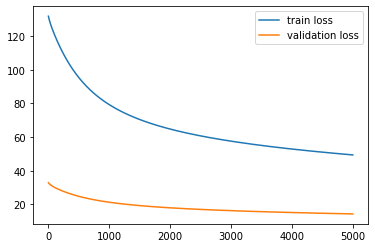

In [17]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train loss", "validation loss"])

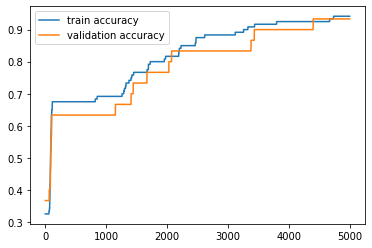

In [18]:
plt.plot(train_accuracies)
plt.plot(valid_accuracies)
plt.legend(["train accuracy", "validation accuracy"])

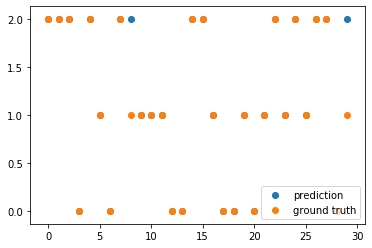

In [19]:
# 预测结果与真实结果重合
plt.scatter(np.arange(Y_valid.size), np.argmax(f.predict(X_valid),axis=1))
plt.scatter(np.arange(Y_valid.size), Y_valid)
plt.legend(["prediction", "ground truth"])